## Imports

In [307]:
import os
import datetime
print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

import time
import glob
import tables as tb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce

2018-06-07 00:21:58


In [308]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [309]:
from invisible_cities.database import load_db

import invisible_cities.sierpe.blr as blr

import invisible_cities.reco.tbl_functions as tbl
import invisible_cities.reco.peak_functions as pkf
import invisible_cities.reco.calib_sensors_functions as csf

from   invisible_cities.evm.ic_containers  import S12Params 
from   invisible_cities.evm.ic_containers  import CalibVectors
from   invisible_cities.evm.ic_containers  import DeconvParams
from   invisible_cities.evm.ic_containers  import ThresholdParams

from   invisible_cities.core.system_of_units_c import units
from   invisible_cities.types.ic_types import minmax
import invisible_cities.icaro.mpl_functions as mpl
import invisible_cities.icaro.signal_functions_mpl as sf
from invisible_cities.icaro.pmaps_mpl import plot_s12
from invisible_cities.sierpe                 import blr

In [310]:
from invisible_cities.reco.dst_functions  import load_dst

In [311]:
from invisible_cities.evm .pmaps             import S1
from invisible_cities.evm .pmaps             import S2

## NB functions

In [312]:
def plot_csum_csum_mau(csum, csum_mau,
                            t_min      =    0,
                            t_max      = 1200,
                            signal_min =    0,
                            signal_max =  200,
                            figsize=(6,6)):
    """Plot signal versus time in mus (tmin, tmax in mus). """
    plt.figure(figsize=figsize)
    tstep = 25 # in ns
    PMTWL = csum.shape[0]
    signal_t = np.arange(0., PMTWL * tstep, tstep)/units.mus
    ax1 = plt.subplot(1, 1, 1)
    ax1.set_xlim([t_min, t_max])
    ax1.set_ylim([signal_min, signal_max])
    mpl.set_plot_labels(xlabel = "t (mus)",
                    ylabel = "signal (pes/adc)")
    plt.plot(signal_t, csum, 'b')
    plt.plot(signal_t, csum_mau, 'r')

In [313]:
def plot_S12(s12s):
    plt.grid(True)
    plt.xlabel(r't (ns)')
    plt.ylabel(r'q (pes)')
    for s12 in s12s:
        plt.plot(s12.times, s12.pmts.waveform(-1))

In [314]:
def plot_pmt_signals_vs_time_mus(pmt_signals,
                                 pmt_active,
                                 t_min      =    0,
                                 t_max      = 1200,
                                 signal_min =    0,
                                 signal_max =  200,
                                 figsize=(12,12)):
    """Plot PMT signals versus time in mus  and return figure."""

    tstep = 25
    PMTWL = pmt_signals[0].shape[0]
    signal_t = np.arange(0., PMTWL * tstep, tstep)/units.mus
    plt.figure(figsize=figsize)
   
   
    plt.ylabel(r'q (pes/adc)')
    for j, i in enumerate(pmt_active):
        plt.grid(True)
        ax1 = plt.subplot(3, 4, j+1)
        ax1.set_xlim([t_min, t_max])
        ax1.set_ylim([signal_min, signal_max])
        plt.plot(signal_t, pmt_signals[i])
        plt.xlabel(r't (mus)')


In [315]:
def plot_pmt_waveforms(pmtwfdf, first=0, last=50000, figsize=(10,10)):
    """plot PMT wf and return figure"""
    plt.figure(figsize=figsize)
    for i in range(len(pmtwfdf)):
        ax = plt.subplot(3, 4, i+1)
        plt.xlabel(r't (mus)')
        plt.plot(pmtwfdf[i][first:last])


In [316]:
def plot_sipm_map(sipm_cal, t_min=0, t_max=1300, zoom=False):
    
    sipm_sums_w = np.sum(sipm_cal[:, t_min:t_max], axis=1)
    
    plt.figure()
    sipms_ = sipm_sums_w > 0 
    x = xs[sipms_]
    y = ys[sipms_]
    q = sipm_sums_w[sipms_]
    print(np.argwhere(sipms_))
    plt.scatter(x, y, s=10, c=q, cmap="jet")
    
    if not zoom:
        plt.xlim(-200, 200)
        plt.ylim(-200, 200)
    plt.colorbar()

## Data base

In [393]:
run_number = 5784
DataPMT = load_db.DataPMT(run_number)
DataSiPM = load_db.DataSiPM(run_number)
xs = DataSiPM.X.values
ys = DataSiPM.Y.values
pmt_active = np.nonzero(DataPMT.Active.values)[0].tolist()

In [394]:
channel_id = DataPMT.ChannelID.values
coeff_blr = abs(DataPMT.coeff_blr.values)
coeff_c = abs(DataPMT.coeff_c .values)
adc_to_pes = abs(DataPMT.adc_to_pes.values)
adc_to_pes_sipm = abs(DataSiPM.adc_to_pes.values)

In [395]:
DataPMT

,SensorID,ChannelID,PmtID,Active,X,Y,coeff_blr,coeff_c,adc_to_pes,noise_rms,Sigma
0,0,0,PMT1,1,-23.9414,65.7785,0.000530,4.250400e-07,23.1013,0.77,9.98610
1,1,12,PMT3,1,-44.9951,-53.6231,0.000533,3.599900e-07,24.5725,0.00,11.49370
2,2,1,PMT2,1,68.9365,-12.1554,0.000530,5.525500e-07,27.4819,0.81,10.84410
3,3,13,PMT4,1,0.0000,185.0000,0.000526,3.563900e-07,27.9459,0.00,11.37120
4,4,19,PMTC,1,-118.9160,141.7180,0.000520,3.804100e-07,33.3792,0.75,12.29650
5,5,18,PMTB,1,-182.1890,32.1249,0.000529,5.704900e-07,23.4389,0.75,9.81317
6,6,7,PMTA,1,-160.2150,-92.5000,0.000518,5.597400e-07,28.0301,0.00,10.37830
7,7,6,PMT9,1,-63.2737,-173.8430,0.000528,5.918400e-07,35.3823,0.00,13.30200
8,8,2,PMT8,1,63.2737,-173.8430,0.000525,4.849600e-07,25.6770,0.00,9.95530
9,9,16,PMT7,1,160.2150,-92.5000,0.000527,4.763500e-07,28.2193,0.00,10.34620


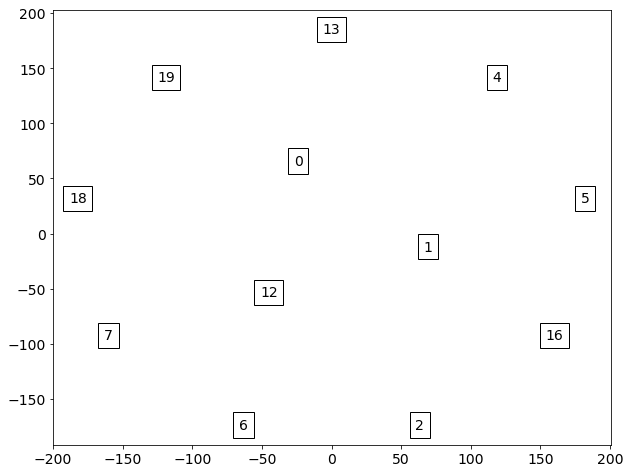

In [396]:
mpl.draw_pmt_map(run_number)

In [397]:
pmt_active

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

In [398]:
adc_to_pes

array([ 23.1013,  24.5725,  27.4819,  27.9459,  33.3792,  23.4389,
        28.0301,  35.3823,  25.677 ,  28.2193,  21.7387,  23.5544])

In [399]:
sipm_adc_to_pes = DataSiPM.adc_to_pes.values

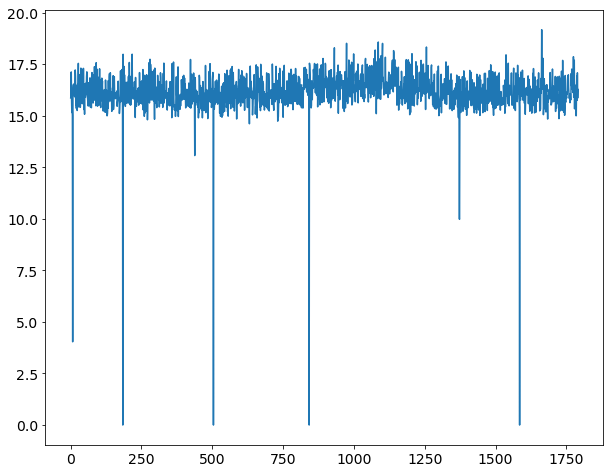

In [400]:
plt.plot(adc_to_pes_sipm)

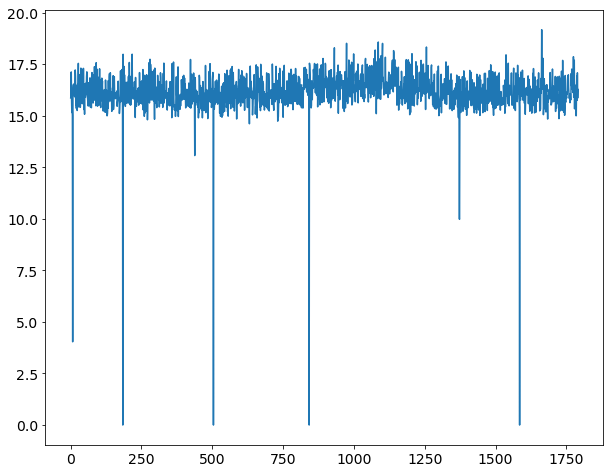

In [325]:
plt.plot(sipm_adc_to_pes)

## Input file

In [402]:
filename = '/Users/jjgomezcadenas/Projects/ICDEV/data/5784/run_5784_1731_waveforms.h5'
input_files = [filename]
h5rwf = tb.open_file(filename, "r") 

In [403]:
pmtrwf = h5rwf.root.RD.pmtrwf
sipmrwf = h5rwf.root.RD.sipmrwf

In [404]:
NEVT, NPMT, PMTWL = pmtrwf.shape
_, NSIPM, SIPMWL = sipmrwf.shape

In [405]:
print("""
        Number of events in file = {}
        Number of PMTs = {}
        PMTWL = {}
        Number of SiPMs = {}
        SiPMWL = {}
      """.format(NEVT, NPMT, PMTWL, NSIPM, SIPMWL))


        Number of events in file = 164
        Number of PMTs = 12
        PMTWL = 52000
        Number of SiPMs = 1792
        SiPMWL = 1300
      


In [406]:
evts = h5rwf.root.Run.events[:]

## S1 and S2 parameters

In [454]:
s1params = S12Params(time = minmax(min    = 100 * units.mus,
                                   max    = 640 * units.mus),
                           stride = 5,
                           length = minmax(min = 5, max = 20),  #250 ns -- 50 ns
                           rebin_stride  = 1)

In [455]:
s2params = S12Params(time = minmax(min    = 640 * units.mus,
                                   max    = 800 * units.mus),
                           stride = 40,
                           length = minmax(min = 80, max = 1e5),  # 4 mus --
                           rebin_stride  = 40)

## Events

## Event 0

In [411]:
event=0

In [413]:
evts[event]

(283885, 1528345392625)

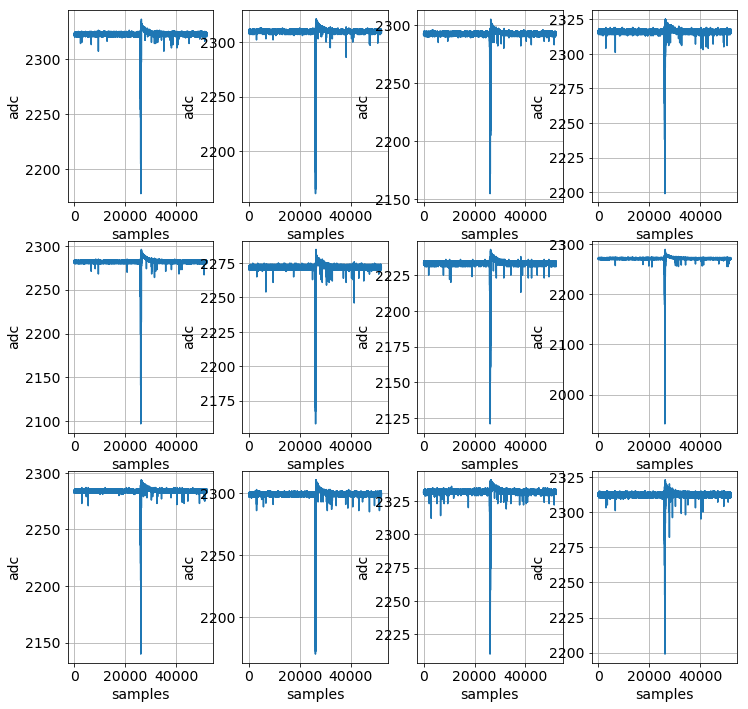

In [414]:
sf.plot_pmt_waveforms(pmtrwf[event], zoom=False, window_size=800, figsize=(12,12))

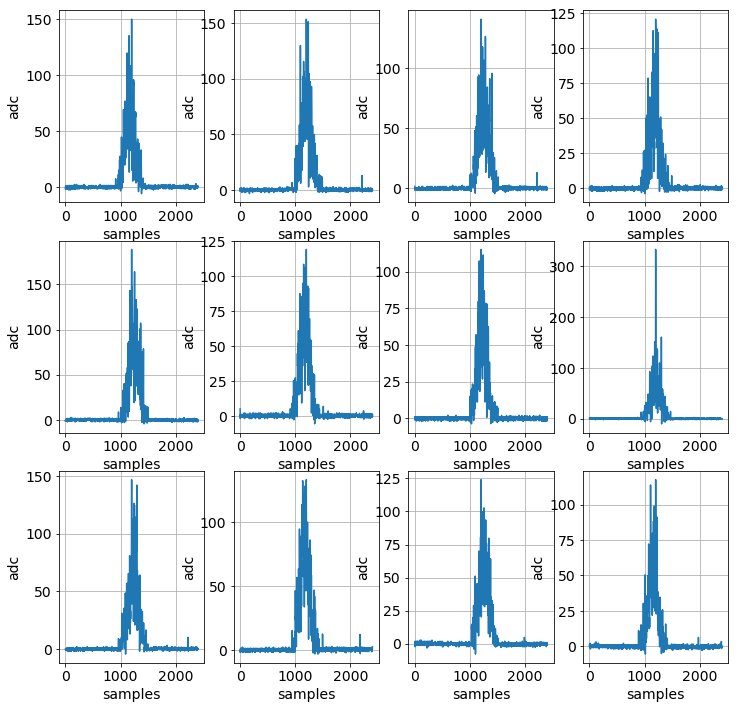

In [415]:
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)

sf.plot_pmt_waveforms(CWF, zoom=True, window_size=1200, figsize=(12,12))

- Calibrated signal in all PMTs

In [416]:
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes, n_MAU = 100, thr_MAU = 3)

- Calibrated sum

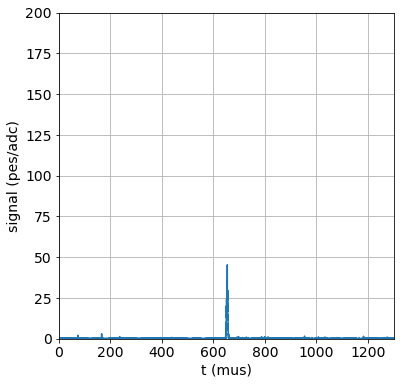

In [417]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 1300,
                            signal_min =    0,
                            signal_max =  200,
                            figsize=(6,6))

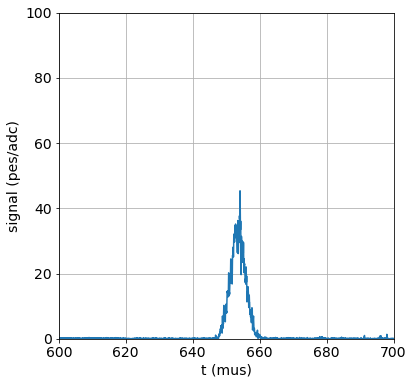

In [418]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =600,
                            t_max      = 700,
                            signal_min =    0,
                            signal_max =  100,
                            figsize=(6,6))

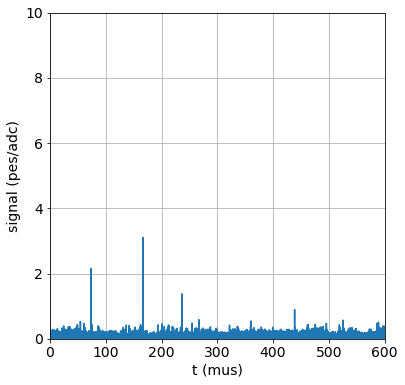

In [419]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 600,
                            signal_min =    0,
                            signal_max =  10,
                            figsize=(6,6))

#### Search for S1 and S2a

In [420]:
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 0.5 * units.pes)

In [421]:
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)

In [422]:
s1s

[
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 11
       Times: [ 73.75   73.775  73.8    73.825  73.85   73.875  73.9    73.925  73.95
 73.975  74.   ] µs
       Time @ max energy: 73.8
       Width: 0.25 µs
       Height: 2.1546495044870024 pes
       Energy: 11.420638725897849 pes
       Charge: 0.0 pes
       RMS: 0.0727875861246002 µs, 
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 8
 Times: [ 166.225  166.25   166.275  166.3    166.325  166.35   166.375  166.4  ] µs
 Time @ max energy: 166.325
 Width: 0.175 µs
 Height: 3.1098249430489755 pes
 Energy: 16.968806383792327 pes
 Charge: 0.0 pes
 RMS: 0.04732367181715426 µs, 
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 7
 Times: [ 236.3    236.325  236.35   236.375  236.4    236.425  236.45 ] µs
 Time @ max energy: 236.4
 Width: 0.15 µs
 Height: 1.3772335398365474 pes
 Energy: 6.6955012746901 pes
 Charge: 0.0 pe

In [423]:
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 2.0 * units.pes)

In [424]:
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)

In [425]:
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 12
       Times: [ 648.65682395  649.62167583  650.61957396  651.61729644  652.60581868
 653.60500195  654.55126423  655.55205277  656.55352311  657.55871526
 658.42965902  659.25026508] µs
       Time @ max energy: 653.6050019459948
       Width: 10.59344112740655 µs
       Height: 1279.2430666180446 pes
       Energy: 7353.13623062671 pes
       Charge: 0.0 pes
       RMS: 2.1502183634634724 µs]

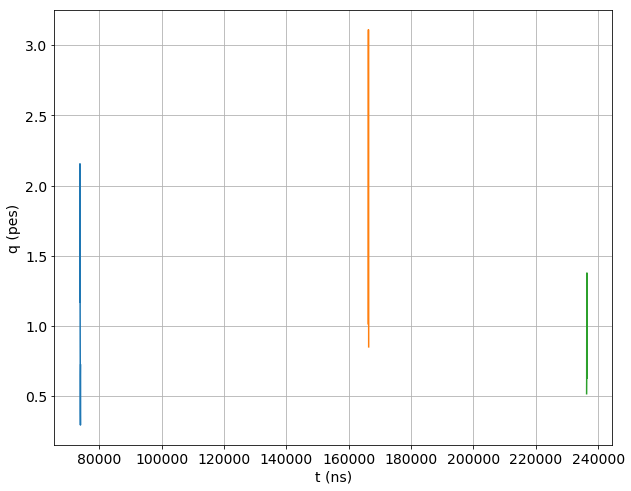

In [426]:
plot_S12(s1s)

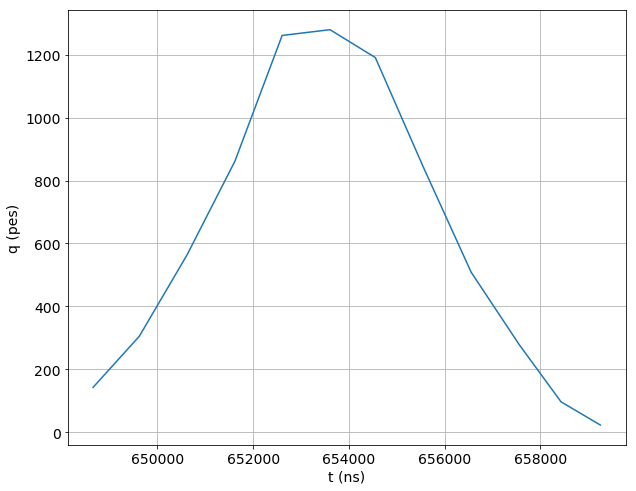

In [427]:
plot_S12(s2s)

In [428]:
sipm_cal = csf.calibrate_sipms(sipmrwf[event], sipm_adc_to_pes, thr=5,
                          bls_mode=csf.BlsMode.mode)

[[   7]
 [ 605]
 [ 606]
 [ 613]
 [ 614]
 [ 615]
 [ 623]
 [1027]
 [1352]
 [1392]
 [1437]]


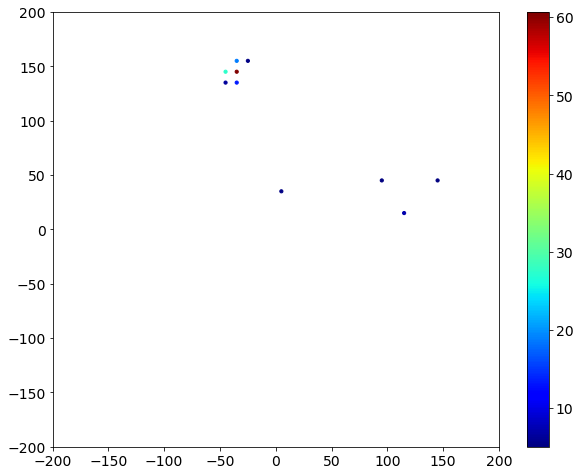

In [429]:
plot_sipm_map(sipm_cal)

## Event 1

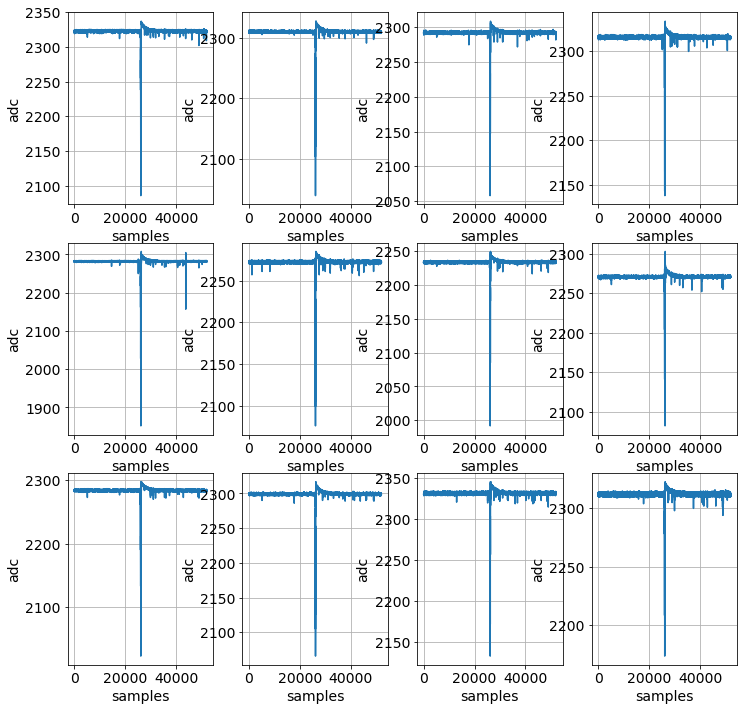

In [430]:
event=1
sf.plot_pmt_waveforms(pmtrwf[event], zoom=False, window_size=800, figsize=(12,12))

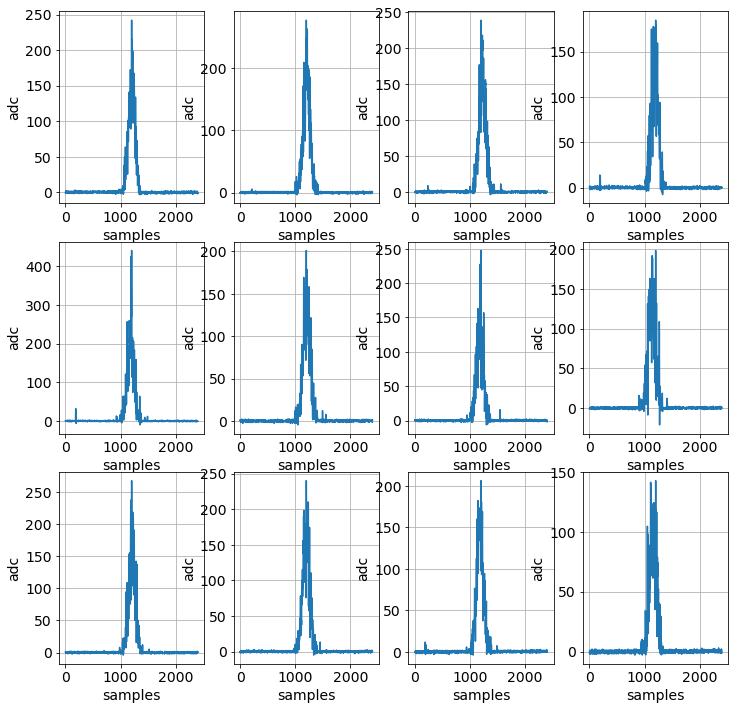

In [431]:
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)
sf.plot_pmt_waveforms(CWF, zoom=True, window_size=1200, figsize=(12,12))

In [432]:
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes)

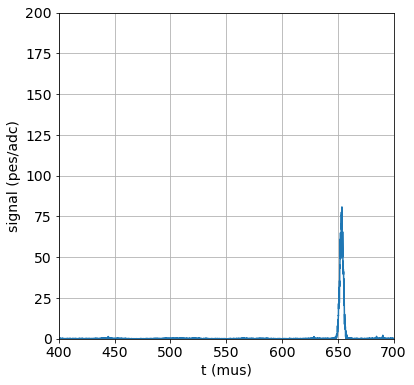

In [433]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =400,
                            t_max      = 700,
                            signal_min =    0,
                            signal_max =  200,
                            figsize=(6,6))

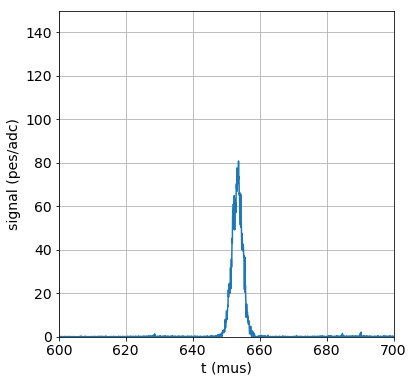

In [434]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =600,
                            t_max      = 700,
                            signal_min =    0,
                            signal_max =  150,
                            figsize=(6,6))

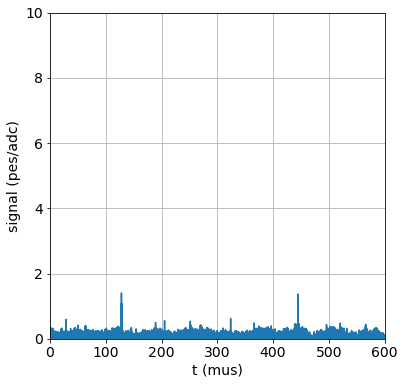

In [435]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 600,
                            signal_min =    0,
                            signal_max =  10,
                            figsize=(6,6))

In [436]:
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s1s

[
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 9
       Times: [ 444.25   444.275  444.3    444.325  444.35   444.375  444.4    444.425
 444.45 ] µs
       Time @ max energy: 444.425
       Width: 0.2 µs
       Height: 1.3744522087328723 pes
       Energy: 10.289957285099572 pes
       Charge: 0.0 pes
       RMS: 0.060842178817612856 µs, 
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 13
       Times: [ 628.4    628.425  628.45   628.475  628.5    628.525  628.55   628.575
 628.6    628.625  628.65   628.675  628.7  ] µs
       Time @ max energy: 628.65
       Width: 0.3 µs
       Height: 1.3344666331827042 pes
       Energy: 11.207804269491449 pes
       Charge: 0.0 pes
       RMS: 0.09402782335831603 µs]

In [437]:
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 11
       Times: [ 648.35488141  649.44740335  650.43624453  651.406399    652.34591857
 653.35317393  654.29886815  655.27130019  656.26019775  657.24781439
 658.12425832] µs
       Time @ max energy: 653.3531739309935
       Width: 9.769376912167646 µs
       Height: 2850.6877220621864 pes
       Energy: 10992.016558156429 pes
       Charge: 0.0 pes
       RMS: 1.5334562515660353 µs]

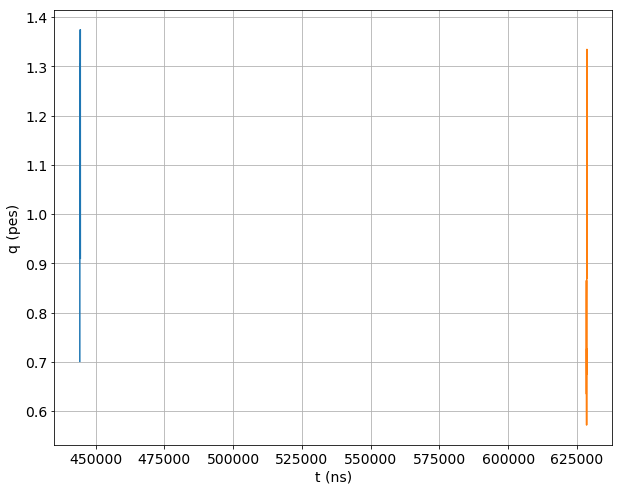

In [439]:
plot_S12(s1s)

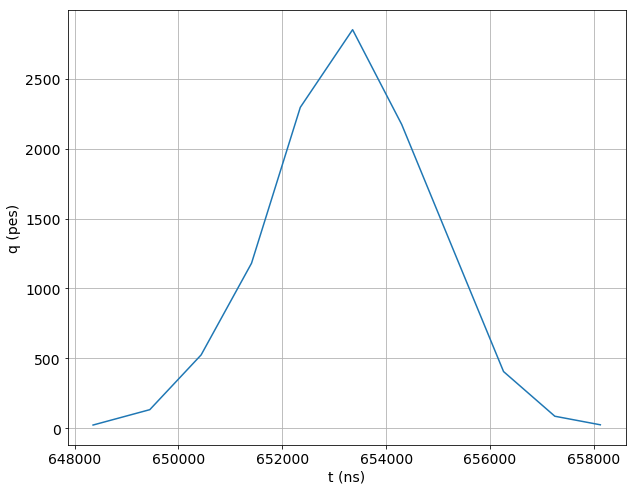

In [438]:
plot_S12(s2s)

[[   7]
 [ 346]
 [ 440]
 [ 441]
 [ 442]
 [ 511]
 [ 771]
 [ 772]
 [ 773]
 [ 774]
 [ 780]
 [ 781]
 [ 782]
 [ 789]
 [ 817]
 [1547]]


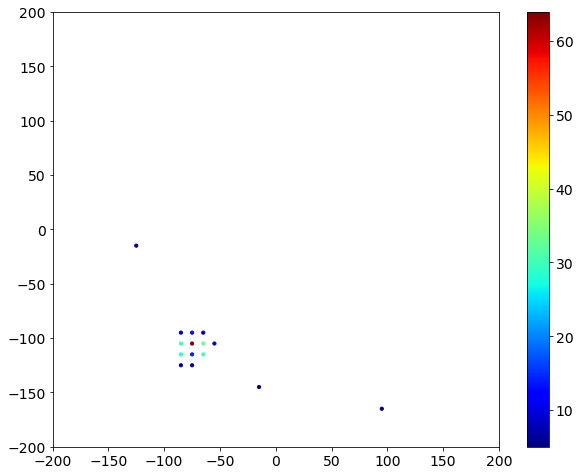

In [445]:
sipm_cal = csf.calibrate_sipms(sipmrwf[event], sipm_adc_to_pes, thr=5,
                          bls_mode=csf.BlsMode.mode)
plot_sipm_map(sipm_cal)

## Event 2

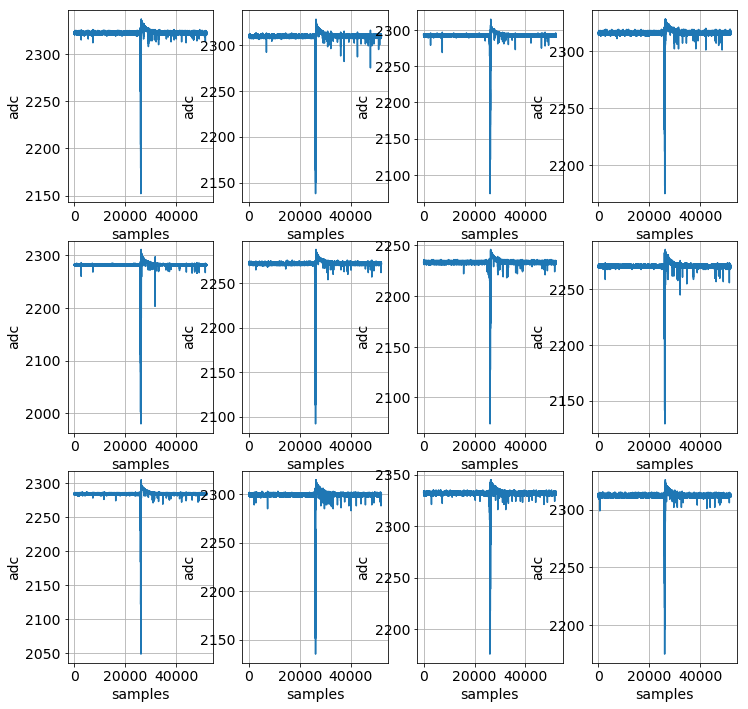

In [447]:
event=2
sf.plot_pmt_waveforms(pmtrwf[event], zoom=False, window_size=800, figsize=(12,12))

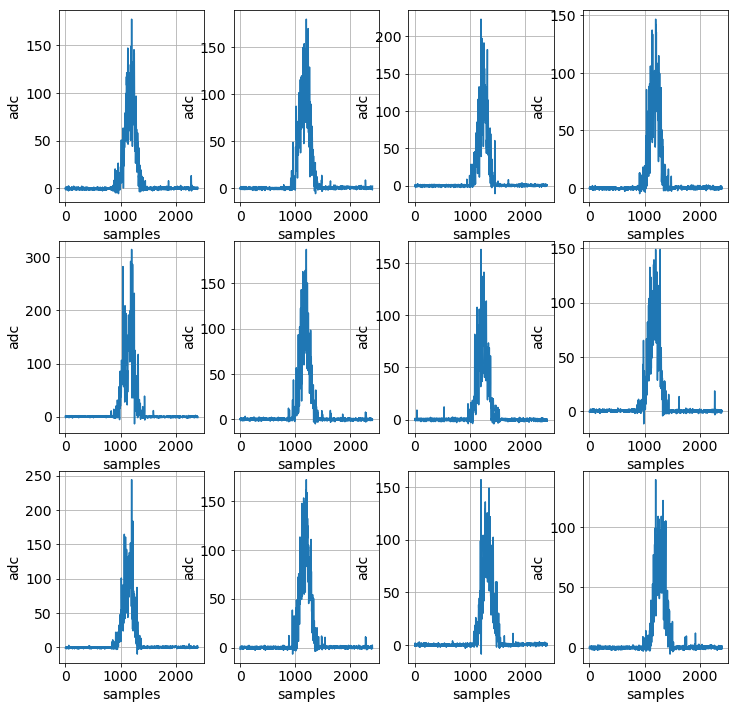

In [448]:
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)
sf.plot_pmt_waveforms(CWF, zoom=True, window_size=1200, figsize=(12,12))

In [449]:
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes)

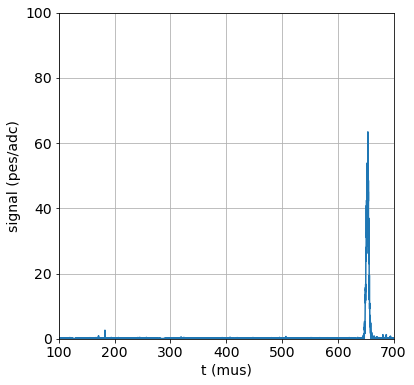

In [450]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =100,
                            t_max      = 700,
                            signal_min =    0,
                            signal_max =  100,
                            figsize=(6,6))

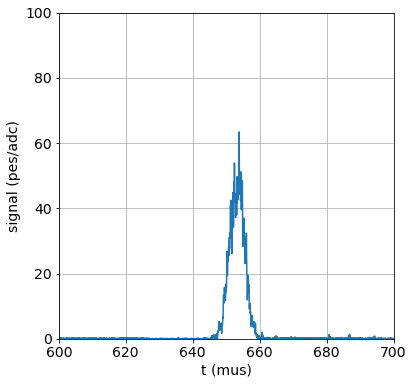

In [452]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =600,
                            t_max      = 700,
                            signal_min =    0,
                            signal_max =  100,
                            figsize=(6,6))

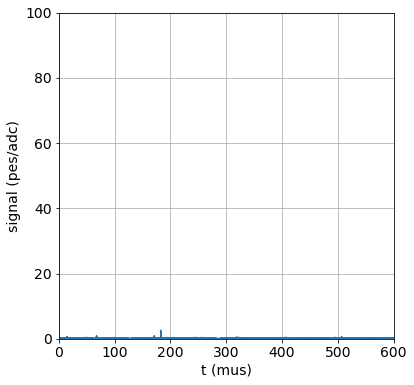

In [453]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 600,
                            signal_min =    0,
                            signal_max =  100,
                            figsize=(6,6))

In [456]:
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s1s

[
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 8
 Times: [ 182.55   182.575  182.6    182.625  182.65   182.675  182.7    182.725] µs
 Time @ max energy: 182.625
 Width: 0.175 µs
 Height: 2.6341824027768195 pes
 Energy: 13.57272024716897 pes
 Charge: 0.0 pes
 RMS: 0.04514278268913181 µs]

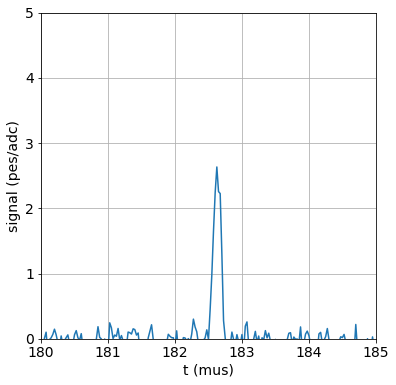

In [460]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =180,
                            t_max      = 185,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

In [457]:
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 14
       Times: [ 646.32050098  647.50385305  648.31389009  649.40967846  650.39024386
 651.35333083  652.34667866  653.36289896  654.3228065   655.31671577
 656.27170475  657.26606339  658.2854526   659.09550259] µs
       Time @ max energy: 654.3228064968876
       Width: 12.775001607472543 µs
       Height: 1850.7489879918671 pes
       Energy: 10741.0180250485 pes
       Charge: 0.0 pes
       RMS: 2.173805544493696 µs]

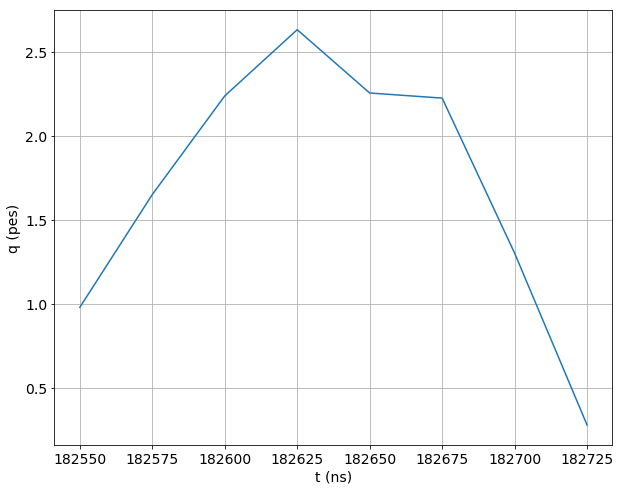

In [459]:
plot_S12(s1s)

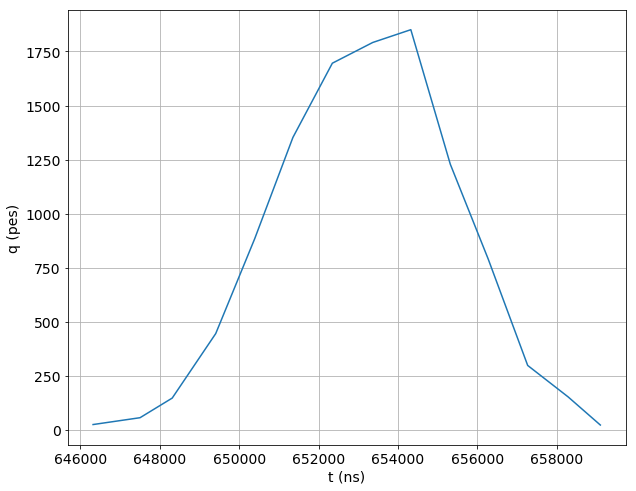

In [458]:
plot_S12(s2s)

[[   7]
 [ 346]
 [ 440]
 [ 441]
 [ 442]
 [ 511]
 [ 771]
 [ 772]
 [ 773]
 [ 774]
 [ 780]
 [ 781]
 [ 782]
 [ 789]
 [ 817]
 [1547]]


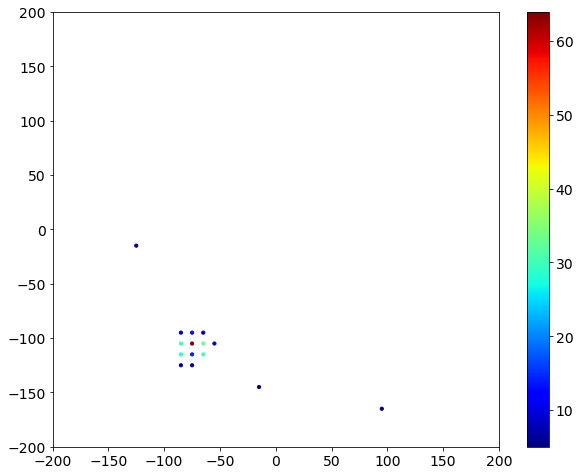

In [446]:
sipm_cal = csf.calibrate_sipms(sipmrwf[event], sipm_adc_to_pes, thr=5,
                          bls_mode=csf.BlsMode.mode)
plot_sipm_map(sipm_cal)

## Event 3

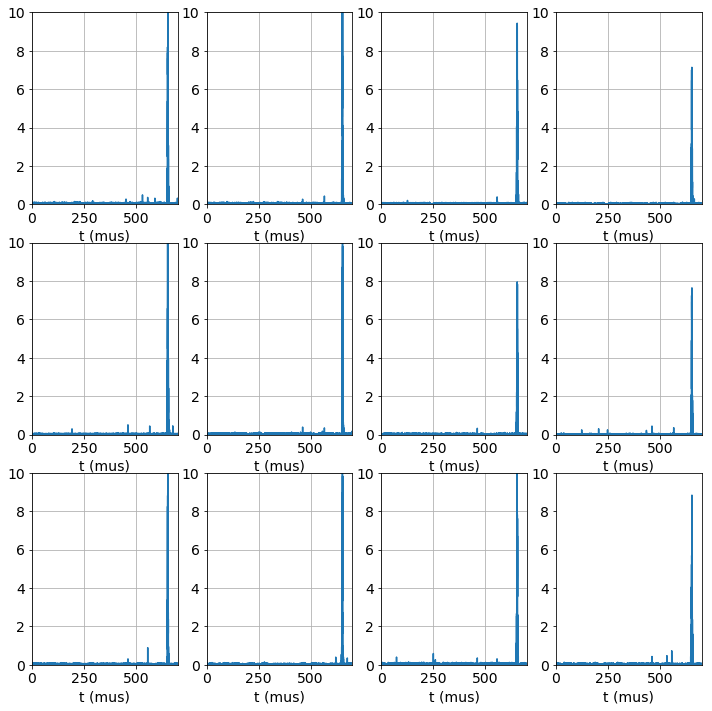

In [461]:
event=3
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes)
plot_pmt_signals_vs_time_mus(ccwfs,
                                pmt_active,
                                t_min      =    0,
                                t_max      = 700,
                                signal_min =    0,
                                signal_max =  10,
                                 figsize=(12,12))

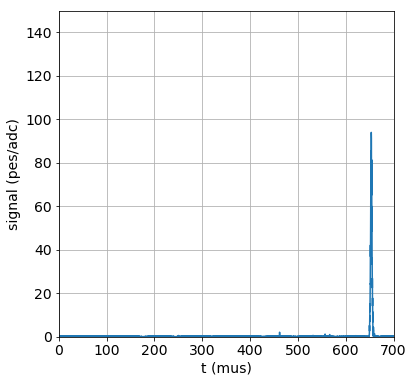

In [462]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 700,
                            signal_min =    0,
                            signal_max =  150,
                            figsize=(6,6))

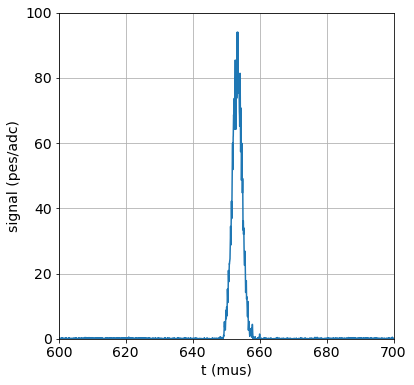

In [463]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =600,
                            t_max      = 700,
                            signal_min =    0,
                            signal_max =  100,
                            figsize=(6,6))

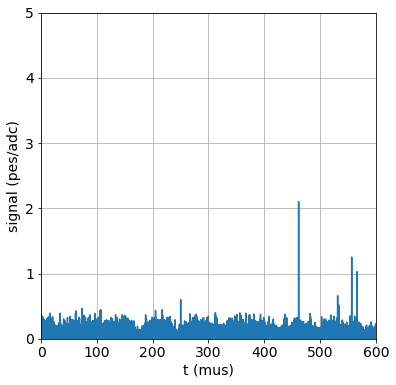

In [464]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 600,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

In [465]:
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s1s

[
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 7
 Times: [ 461.55   461.575  461.6    461.625  461.65   461.675  461.7  ] µs
 Time @ max energy: 461.6
 Width: 0.15 µs
 Height: 2.1024106687348767 pes
 Energy: 9.860401716288889 pes
 Charge: 0.0 pes
 RMS: 0.041973648676523125 µs, 
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 15
       Times: [ 556.5    556.525  556.55   556.575  556.6    556.625  556.65   556.675
 556.7    556.725  556.75   556.775  556.8    556.825  556.85 ] µs
       Time @ max energy: 556.675
       Width: 0.35 µs
       Height: 1.2518301130185143 pes
       Energy: 10.24408774381219 pes
       Charge: 0.0 pes
       RMS: 0.0993359073853407 µs]

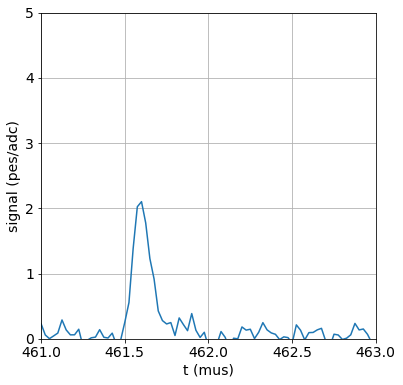

In [470]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =461,
                            t_max      = 463,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

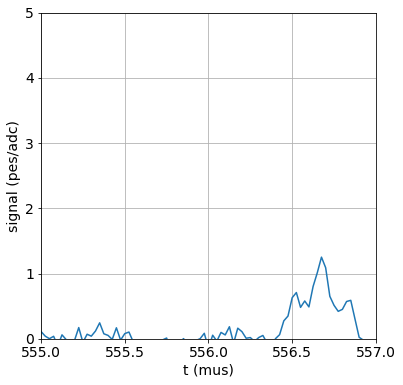

In [471]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =555,
                            t_max      = 557,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

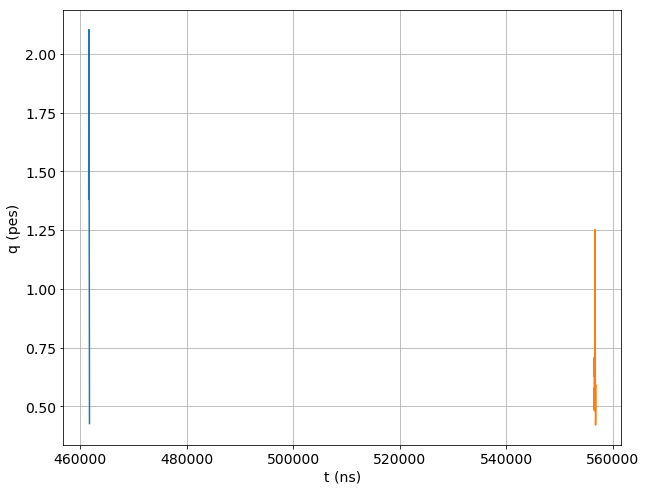

In [466]:
plot_S12(s1s)

In [467]:
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 9
       Times: [ 649.83948777  650.79421957  651.78628932  652.71994108  653.69349525
 654.65538455  655.62946485  656.55096132  657.58995471] µs
       Time @ max energy: 653.6934952479279
       Width: 7.750466940797749 µs
       Height: 3155.734281566006 pes
       Energy: 11996.519928694219 pes
       Charge: 0.0 pes
       RMS: 1.4187737015978041 µs]

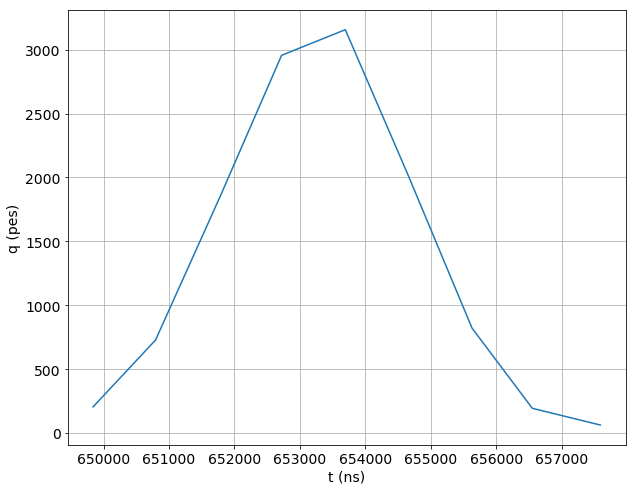

In [468]:
plot_S12(s2s)

[[   7]
 [1445]
 [1446]
 [1452]
 [1453]
 [1454]
 [1455]
 [1460]
 [1461]
 [1462]
 [1463]
 [1469]
 [1470]
 [1783]]


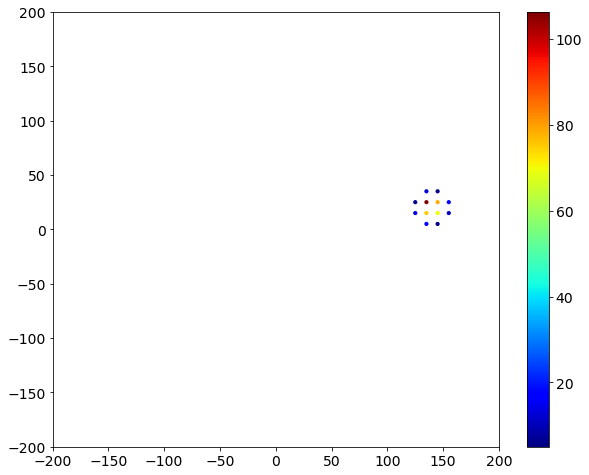

In [469]:
sipm_cal = csf.calibrate_sipms(sipmrwf[event], sipm_adc_to_pes, thr=5,
                          bls_mode=csf.BlsMode.mode)
plot_sipm_map(sipm_cal)

## Event 4

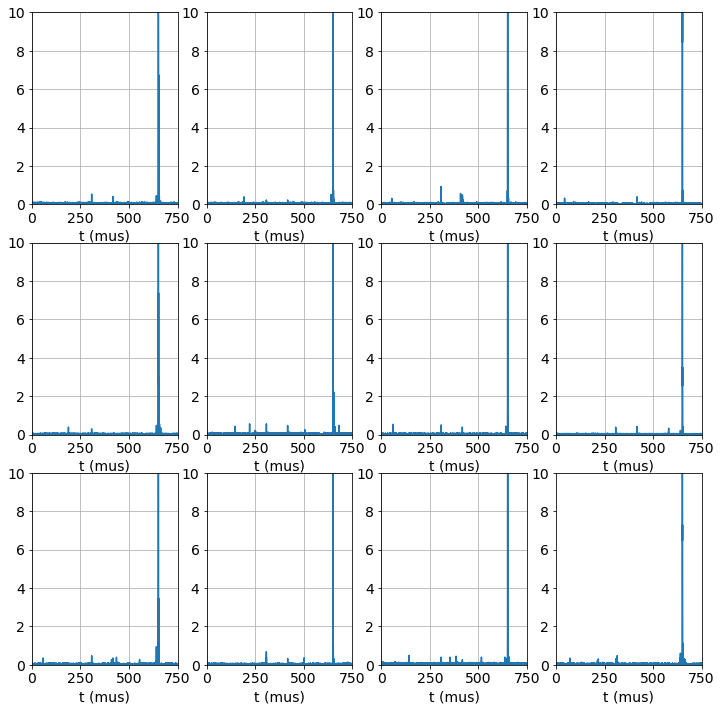

In [472]:
event=4
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes)
plot_pmt_signals_vs_time_mus(ccwfs,
                                pmt_active,
                                t_min      =    0,
                                t_max      = 750,
                                signal_min =    0,
                                signal_max =  10,
                                 figsize=(12,12))

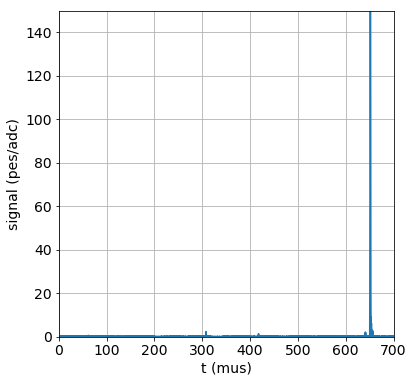

In [473]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 700,
                            signal_min =    0,
                            signal_max =  150,
                            figsize=(6,6))

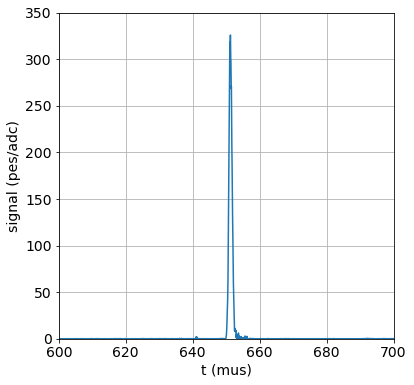

In [478]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =600,
                            t_max      = 700,
                            signal_min =    0,
                            signal_max =  350,
                            figsize=(6,6))

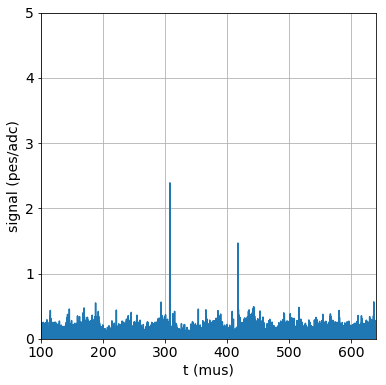

In [479]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =100,
                            t_max      = 640,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

In [480]:
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s1s

[
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 15
       Times: [ 307.575  307.6    307.625  307.65   307.675  307.7    307.725  307.75
 307.775  307.8    307.825  307.85   307.875  307.9    307.925] µs
       Time @ max energy: 307.725
       Width: 0.35 µs
       Height: 2.3904583361623195 pes
       Energy: 22.554277168950147 pes
       Charge: 0.0 pes
       RMS: 0.08913856192229945 µs, 
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 16
       Times: [ 417.375  417.4    417.425  417.45   417.475  417.5    417.525  417.55
 417.575  417.6    417.625  417.65   417.675  417.7    417.725  417.75 ] µs
       Time @ max energy: 417.5
       Width: 0.375 µs
       Height: 1.4669195788795284 pes
       Energy: 13.23032442000957 pes
       Charge: 0.0 pes
       RMS: 0.11646149535324206 µs]

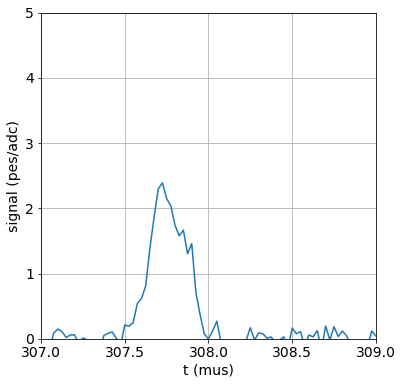

In [482]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =307,
                            t_max      = 309,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

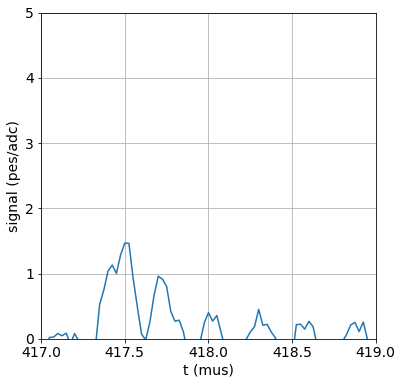

In [483]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =417,
                            t_max      = 419,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

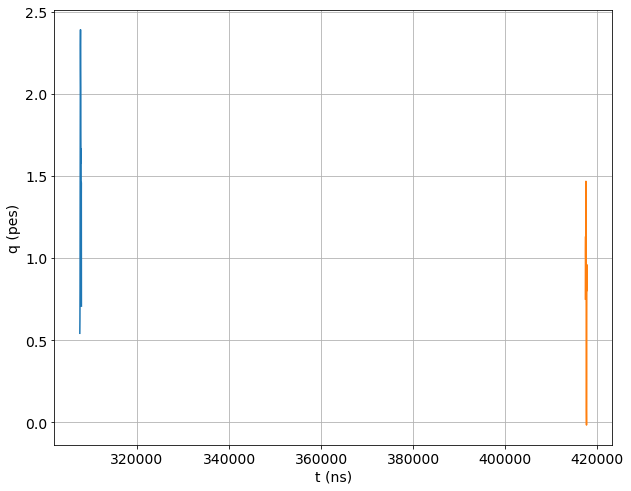

In [484]:
plot_S12(s1s)

In [485]:
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 7
       Times: [ 650.70506278  651.37703806  652.18599916  653.40404671  654.1959696
 655.40124911  656.21168097] µs
       Time @ max energy: 651.3770380595635
       Width: 5.506618194744806 µs
       Height: 10220.114277367633 pes
       Energy: 14839.59963190851 pes
       Charge: 0.0 pes
       RMS: 0.47079855466891035 µs]

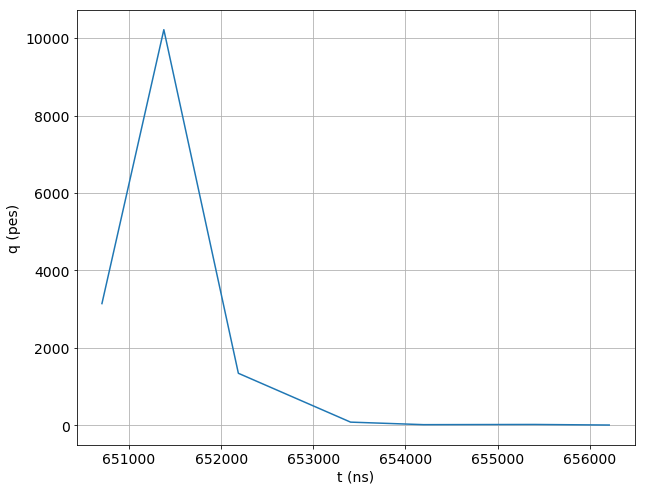

In [486]:
plot_S12(s2s)

[[   7]
 [ 304]
 [ 418]
 [ 419]
 [ 426]
 [ 427]
 [ 428]
 [ 434]
 [ 435]
 [ 436]
 [ 442]
 [ 443]
 [ 444]
 [ 774]
 [ 775]
 [1425]
 [1540]]


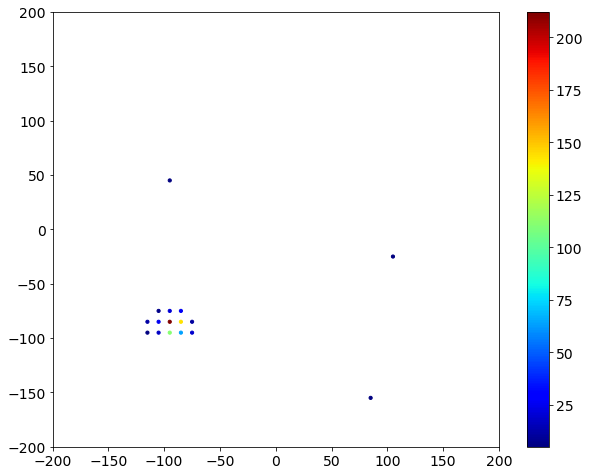

In [487]:
sipm_cal = csf.calibrate_sipms(sipmrwf[event], sipm_adc_to_pes, thr=5,
                          bls_mode=csf.BlsMode.mode)
plot_sipm_map(sipm_cal)

## Event 5

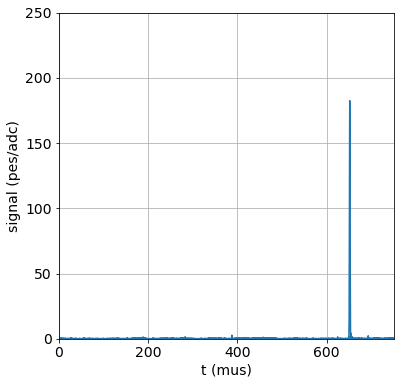

In [488]:
event=5
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes)
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 750,
                            signal_min =    0,
                            signal_max =  250,
                            figsize=(6,6))

In [489]:
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s1s

[
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 12
       Times: [ 188.425  188.45   188.475  188.5    188.525  188.55   188.575  188.6
 188.625  188.65   188.675  188.7  ] µs
       Time @ max energy: 188.65
       Width: 0.275 µs
       Height: 1.3530998930540832 pes
       Energy: 8.833736280157463 pes
       Charge: 0.0 pes
       RMS: 0.09110058695765456 µs, 
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 18
       Times: [ 282.625  282.65   282.675  282.7    282.725  282.75   282.775  282.8
 282.825  282.85   282.875  282.9    282.925  282.95   282.975  283.
 283.025  283.05 ] µs
       Time @ max energy: 282.775
       Width: 0.425 µs
       Height: 1.4257896853357517 pes
       Energy: 19.427285604832587 pes
       Charge: 0.0 pes
       RMS: 0.12536661726346113 µs, 
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 8
 Times: [ 387.525  3

In [490]:
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 6
       Times: [ 650.38898633  651.21086377  652.03287656  652.93965807  654.03730841
 654.99461493] µs
       Time @ max energy: 652.0328765619058
       Width: 4.605628596942522 µs
       Height: 5413.4979203735475 pes
       Energy: 11646.949595730319 pes
       Charge: 0.0 pes
       RMS: 0.6200227663074903 µs]

## Event 7

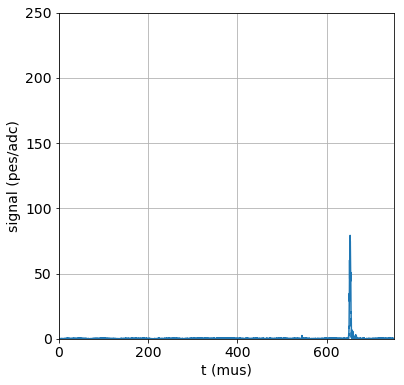

In [295]:
event=7
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes)
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 750,
                            signal_min =    0,
                            signal_max =  250,
                            figsize=(6,6))

In [296]:
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s1s

[
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 11
       Times: [ 544.7    544.725  544.75   544.775  544.8    544.825  544.85   544.875
 544.9    544.925  544.95 ] µs
       Time @ max energy: 544.75
       Width: 0.25 µs
       Height: 2.4983535474677554 pes
       Energy: 15.37387711929477 pes
       Charge: 0.0 pes
       RMS: 0.06881291970155648 µs]

In [297]:
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 8
       Times: [ 649.47399869  650.48086139  651.38706964  652.3469753   653.29880857
 654.24626249  655.20344816  656.04981505] µs
       Time @ max energy: 652.3469752982218
       Width: 6.575816364205326 µs
       Height: 2837.5670098497294 pes
       Energy: 9354.63152196649 pes
       Charge: 0.0 pes
       RMS: 1.2065653292825416 µs]

[[   7]
 [  25]
 [ 179]
 [ 776]
 [1208]
 [1209]
 [1538]
 [1539]
 [1540]
 [1541]
 [1542]
 [1547]
 [1548]
 [1549]
 [1550]
 [1556]
 [1557]
 [1558]
 [1564]
 [1670]]


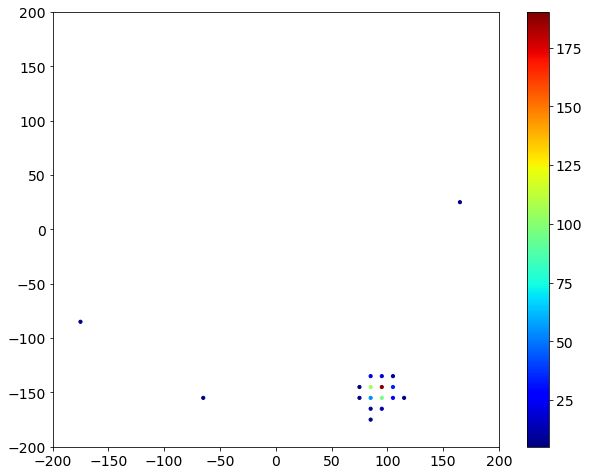

In [491]:
sipm_cal = csf.calibrate_sipms(sipmrwf[event], sipm_adc_to_pes, thr=5,
                          bls_mode=csf.BlsMode.mode)
plot_sipm_map(sipm_cal)

## Event 8

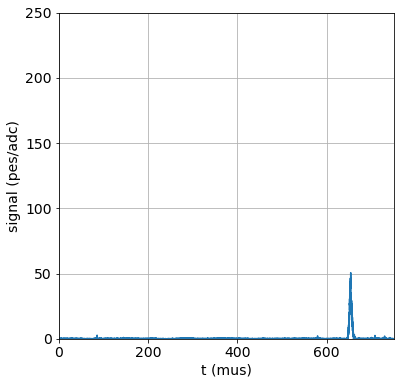

In [492]:
event=8
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes)
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 750,
                            signal_min =    0,
                            signal_max =  250,
                            figsize=(6,6))

In [493]:
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s1s

[
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 6
 Times: [ 144.7    144.725  144.75   144.775  144.8    144.825] µs
 Time @ max energy: 144.775
 Width: 0.125 µs
 Height: 1.062000844458278 pes
 Energy: 5.440977204520116 pes
 Charge: 0.0 pes
 RMS: 0.041221484883326304 µs, 
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 16
       Times: [ 579.4    579.425  579.45   579.475  579.5    579.525  579.55   579.575
 579.6    579.625  579.65   579.675  579.7    579.725  579.75   579.775] µs
       Time @ max energy: 579.65
       Width: 0.375 µs
       Height: 2.2371515247193203 pes
       Energy: 16.36400976328754 pes
       Charge: 0.0 pes
       RMS: 0.10183018662022232 µs]

In [494]:
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 16
       Times: [ 647.17568513  648.07258785  649.03131553  650.05158861  651.06255409
 652.02621422  653.05004852  653.99054185  654.96675804  655.98569685
 656.96651304  657.98511707  658.92688336  659.84469839  661.03799774
 662.03474701] µs
       Time @ max energy: 653.9905418495591
       Width: 14.85906187888817 µs
       Height: 1666.0567445878462 pes
       Energy: 9658.419778418916 pes
       Charge: 0.0 pes
       RMS: 2.4944459607356424 µs]

[[   7]
 [ 339]
 [ 340]
 [ 341]
 [ 348]
 [ 349]
 [ 350]
 [ 356]
 [ 357]
 [1373]
 [1620]]


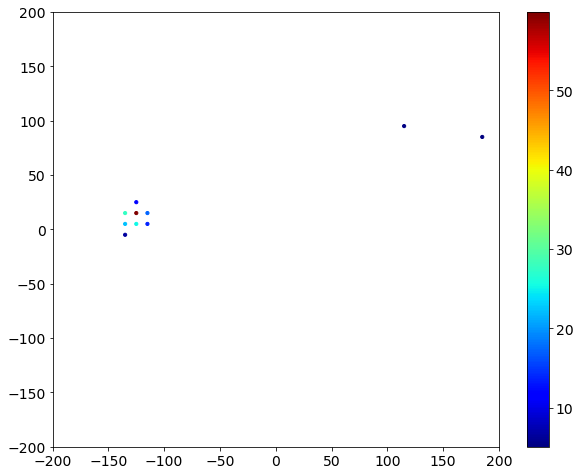

In [495]:
sipm_cal = csf.calibrate_sipms(sipmrwf[event], sipm_adc_to_pes, thr=5,
                          bls_mode=csf.BlsMode.mode)
plot_sipm_map(sipm_cal)

## Event 9

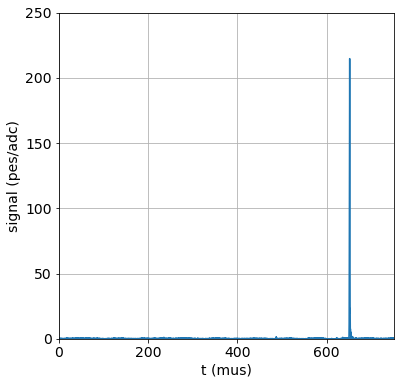

In [496]:
event=9
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes)
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 750,
                            signal_min =    0,
                            signal_max =  250,
                            figsize=(6,6))

In [497]:
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum_mau, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s1s

[
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 5
 Times: [ 235.3    235.325  235.35   235.375  235.4  ] µs
 Time @ max energy: 235.35
 Width: 0.1 µs
 Height: 1.2401200158401933 pes
 Energy: 4.672192514828558 pes
 Charge: 0.0 pes
 RMS: 0.032199099873594664 µs]

In [498]:
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s2s

[
 ---------------------
 S2 instance
 ---------------------
 Number of samples: 5
 Times: [ 650.72717418  651.49255066  652.27634597  653.29010286  654.37669129] µs
 Time @ max energy: 651.4925506622515
 Width: 3.6495171114220284 µs
 Height: 7132.084325510339 pes
 Energy: 10757.990494750455 pes
 Charge: 0.0 pes
 RMS: 0.5167236518622047 µs]

[[   7]
 [  62]
 [ 200]
 [ 261]
 [ 262]
 [ 263]
 [ 268]
 [ 269]
 [ 270]
 [ 271]
 [ 277]
 [ 278]
 [ 279]
 [ 287]
 [1550]]


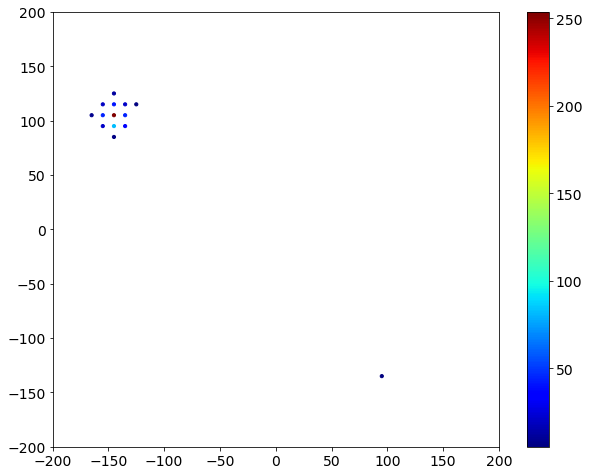

In [499]:
sipm_cal = csf.calibrate_sipms(sipmrwf[event], sipm_adc_to_pes, thr=5,
                          bls_mode=csf.BlsMode.mode)
plot_sipm_map(sipm_cal)

## Event 10

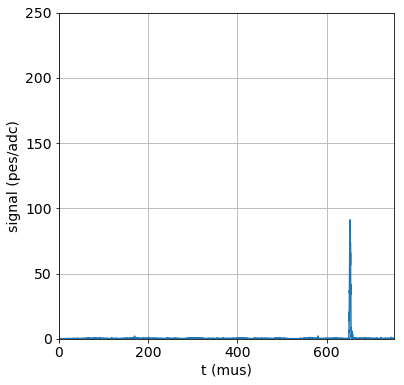

In [500]:
event=10
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes)
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 750,
                            signal_min =    0,
                            signal_max =  250,
                            figsize=(6,6))

In [501]:
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum_mau, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s1s

[
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 8
 Times: [ 169.55   169.575  169.6    169.625  169.65   169.675  169.7    169.725] µs
 Time @ max energy: 169.6
 Width: 0.175 µs
 Height: 1.843711530363468 pes
 Energy: 11.254096337011662 pes
 Charge: 0.0 pes
 RMS: 0.05204191006892893 µs, 
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 11
       Times: [ 581.     581.025  581.05   581.075  581.1    581.125  581.15   581.175
 581.2    581.225  581.25 ] µs
       Time @ max energy: 581.05
       Width: 0.25 µs
       Height: 2.112755124272919 pes
       Energy: 10.59457502482847 pes
       Charge: 0.0 pes
       RMS: 0.07339820191857883 µs]

In [502]:
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 8
       Times: [ 650.2054866   651.11360246  652.04479943  652.97438481  653.90722071
 654.86082292  656.06360115  656.72907918] µs
       Time @ max energy: 652.0447994312294
       Width: 6.523592580889235 µs
       Height: 3059.259707659702 pes
       Energy: 9099.926683479587 pes
       Charge: 0.0 pes
       RMS: 1.0477653155234283 µs]

[[   7]
 [ 208]
 [1624]
 [1677]
 [1678]
 [1685]
 [1686]
 [1687]
 [1692]
 [1693]
 [1694]
 [1695]
 [1701]
 [1702]
 [1703]
 [1709]]


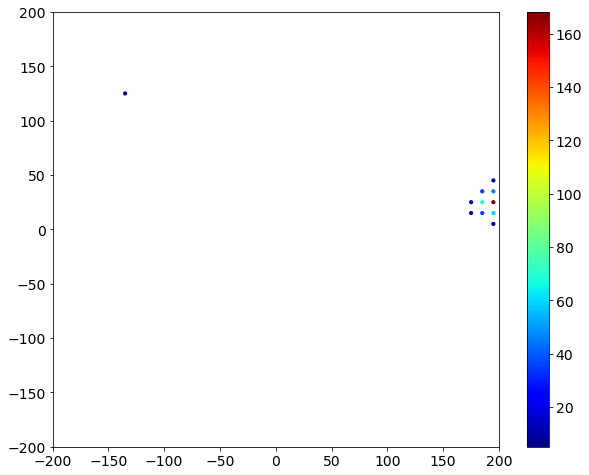

In [503]:
sipm_cal = csf.calibrate_sipms(sipmrwf[event], sipm_adc_to_pes, thr=5,
                          bls_mode=csf.BlsMode.mode)
plot_sipm_map(sipm_cal)